# Importing Required Libraries¶


In [1]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import plotly.express as px
import time
import os
# from collections import Counter
# import copy
import itertools
import glob
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import torchvision
# from torchvision.datasets import ImageFolder
from torchvision import models, transforms
# from torchvision.utils import make_grid

from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.optim import lr_scheduler
# from torch.autograd import Variable
import torch
import gc
import datetime


# Setting Manual Seed for Recreation of results
torch.manual_seed(42)
np.random.seed(0)

In [2]:
def GetImagesFromFolder(PATH,Class_Folder,ext):
    """
    This module can be used to import image data. It also takes care of resizing the images to 240x240 Pixels
    """
    images = [Image.open(file).convert('RGB').resize((240,240),resample=Image.LANCZOS) for e in ext for file in glob.glob(PATH+Class_Folder+'/*.' + e)] 
    print(f"Found {len(images)} in folder {Class_Folder}")
    np.random.shuffle(images)
    return images,np.array([Class_Folder for i in range(len(images))])



# Reading Image Data


In [3]:
DATA_PATH = './Multi-class Weather Dataset/'
FOLDERS = os.listdir(DATA_PATH)
ext = ['jpg','jpeg']
le = LabelEncoder().fit(FOLDERS)

In [4]:
start_time = datetime.datetime.now().replace(microsecond=0)

ALL_IMAGES,ALL_LABELS = [],[]
images_population ={}

for Class_Folder in FOLDERS:
    IMAGES,LABELS = GetImagesFromFolder(DATA_PATH,Class_Folder,ext)
    images_population[Class_Folder] = LABELS.shape[0]
    ALL_IMAGES.extend(IMAGES)
    ALL_LABELS.extend(LABELS)
    
end_time = datetime.datetime.now().replace(microsecond=0)

print(end_time - start_time)

/tmp/ipykernel_11937/2618368367.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  images = [Image.open(file).convert('RGB').resize((240,240),resample=Image.LANCZOS) for e in ext for file in glob.glob(PATH+Class_Folder+'/*.' + e)]


Found 357 in folder Sunrise
Found 300 in folder Cloudy
Found 215 in folder Rain
Found 253 in folder Shine
0:00:10


# Population Distribution of Data:

In [5]:
df = pd.DataFrame.from_dict({'Name':[i for i in images_population.keys()],'#Images':[i for i in images_population.values()]})

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = px.pie(df,values='#Images',names='Name', hole=.3, width=600, height=600,opacity=.80)
fig.update_traces(hoverinfo='label+percent',textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide', title={'text': 'Population of Various Classes','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()


# Splitting Dataset to differernt splits for Training, Tesing & Validation:

In [6]:
from sklearn.model_selection import train_test_split
TRAIN_IMAGES, X_val_test, TRAIN_LABELS, y_val_test = train_test_split(ALL_IMAGES, ALL_LABELS, test_size=0.20, random_state=42,stratify=ALL_LABELS)
VAL_IMAGES, TEST_IMAGES, VAL_LABELS, TEST_LABELS =  train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=42,stratify=y_val_test)

# Creating Custom Dataset:

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, ImageData, Target, transform=None):
        self.ImageData = ImageData
        self.Target = torch.LongTensor(le.transform(Target))
        self.transform = transform

    def __getitem__(self, index):
        x = self.ImageData[index]
        y = self.Target[index]
        if self.transform:
            x = Image.fromarray(np.uint8(np.array(self.ImageData[index]))) # Memory Efficient way
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.ImageData)

In [8]:
# SOURCE: https://youtu.be/y6IEcEBRZks
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in loader:
        channels_sum +=torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean,std

In [9]:
batch_size = 25
transform = transforms.Compose([transforms.Resize((230,230)),transforms.ToTensor()])
dataset = WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4)
mean,std = get_mean_std(loader)
print(f"Data loader has:\n*\tmean= {mean.tolist()}\n*\tstd= {std.tolist()}")

Data loader has:
*	mean= [0.4627096951007843, 0.4568105936050415, 0.4471193552017212]
*	std= [0.2670912742614746, 0.24699556827545166, 0.2886996865272522]


# Data Loader to Mini Batches:


In [10]:
transform = {'train':transforms.Compose([transforms.ColorJitter(),
                                         transforms.RandomRotation(30),
                                         transforms.Resize((240,240)),
                                         transforms.RandomResizedCrop(230),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean,std=std),#transforms.RandomErasing()
                                        ]),
             'val':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()]),
             
             'test':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


batch_size = {'train':25, 'val':50,'test':50}

dataset_classes = ['Cloudy','Rain','Shine','Sunrise']


image_datasets = {'train': WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform['train']),
                  'val':   WeatherDataset(VAL_IMAGES, VAL_LABELS, transform=transform['val']),
                  'test':  WeatherDataset(TEST_IMAGES, TEST_LABELS, transform=transform['test'])
}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

dataloaders = {indx: torch.utils.data.DataLoader(image_datasets[indx], batch_size=batch_size[indx], num_workers=4, pin_memory=True, shuffle=True)
              for indx in batch_size.keys()}

print("Size for Dataset:\n\t* Train: %d\n\t* Valid: %d\n\t* Test: %d"%(dataset_sizes['train'],dataset_sizes['val'],dataset_sizes['test']))

Size for Dataset:
	* Train: 900
	* Valid: 112
	* Test: 113


# Visualization of Training & Validation Data:

In [11]:
# Helper function to display the image
def imshow(img):
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

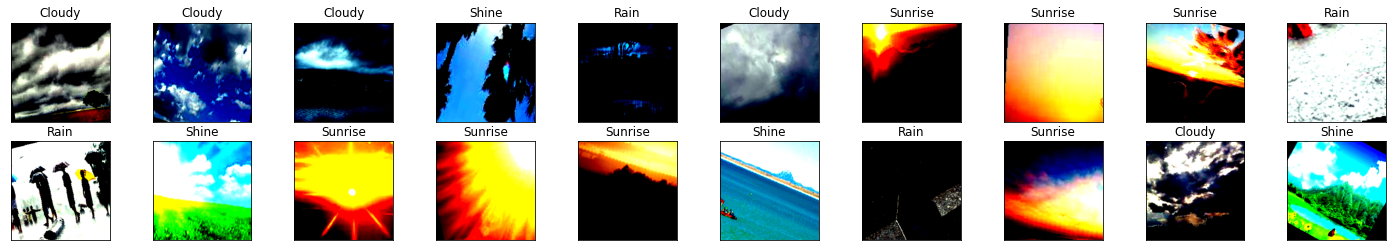

In [12]:
# Get one batch of training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

labels = le.inverse_transform([i.item() for i in labels])

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx])

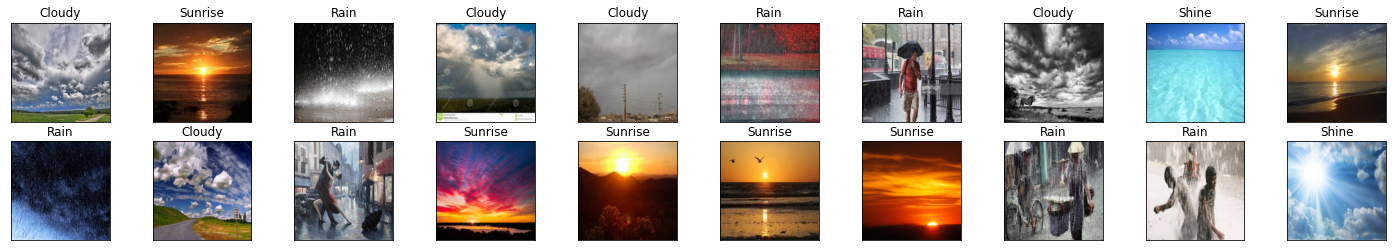

In [13]:
# Get one batch of validation images
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(dataset_classes[labels[idx]])

In [14]:
def train_model(model, criterion, optimizer, model_checkpoint=0, early_stop = 10, num_epochs=5):
    start_time = datetime.datetime.now().replace(microsecond=0)
    model = model.to(device)

    # number of epochs to train the model
    valid_loss_min = np.Inf # track change in validation loss
    early_stop_cnt = 0
    last_epoch_loss = np.Inf
    globaliter = 0

    final_loss = np.Inf

    for epoch in range(1, num_epochs+1):
        globaliter+=1
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0


        ###################
        # train the model #
        ###################
        model.train()
        train_corrects = 0

        for data, target in dataloaders['train']:
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            train_corrects += torch.sum(preds == target.data)

        train_loss = train_loss/len(dataloaders['train'].dataset)
        train_acc = (train_corrects.double()*100)/len(dataloaders['train'].dataset)

        ######################    
        # validate the model #
        ######################
        model.eval()
        val_corrects = 0
        for data, target in dataloaders['val']:
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            val_corrects += torch.sum(preds == target.data)

        # calculate average losses
        valid_loss = valid_loss/len(dataloaders['val'].dataset)
        valid_acc = (val_corrects.double()*100)/len(dataloaders['val'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss:  {:.6f} \tValidation Loss:  {:.6f}'.format(epoch, train_loss, valid_loss))
        print('\t\tTraining Acc:  {:.3f} \t\tValidation Acc:  {:.3f}'.format(train_acc, valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
            if model_checkpoint != 0:
                torch.save(model.state_dict(), '/kaggle/working/model.pt'.format(train_acc, valid_acc))
                print('Model Saved: /kaggle/working/model.pt'.format(train_acc, valid_acc))
            valid_loss_min = valid_loss
        elif valid_loss == np.nan:
            print("Model Loss: NAN")

        if (last_epoch_loss < valid_loss) and last_epoch_loss != np.Inf:
            early_stop_cnt +=1
            if early_stop_cnt == early_stop:
                print('-'*50+"\nEarly Stopping Hit\n"+'-'*50)
                break
            else:
                print('-'*50+f"\n\t\tEarly Stopping Step: {early_stop_cnt}/{early_stop}\n"+'-'*50)
        else:
            early_stop_cnt = 0
            last_epoch_loss = valid_loss

    print(f"Training Completed with best model having loss of {round(valid_loss_min,6)}")
    del data,target
    gc.collect()
    end_time = datetime.datetime.now().replace(microsecond=0)
    print(f'Time Taken: {end_time-start_time}')
    return model


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    size = len(classes)*2
    plt.figure(figsize = (size,size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)

    
def model_verification(loader,batch_size,model,n_classes=5):
    classes = list(le.inverse_transform([i for i in range(n_classes)]))
    prediction_list,label_list = [],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1).detach()
            prediction_list.extend(predicted.tolist())
            label_list.extend(labels.tolist())
            
    cm = confusion_matrix(prediction_list,label_list)
    plot_confusion_matrix(cm, classes)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (num_images,num_images))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {dataset_classes[preds[j]]} | Actual: {dataset_classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()

# Model Trainnig 

In [15]:
n_classes = 4
epochs = 25

n_classes = len(dataset_classes)

model_ft = models.densenet161(pretrained=True)
# Using Model as Feature Extractor
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, n_classes)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/monotera/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100.0%


In [16]:
# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
lr = 0.01
momentum = 0.5
decay = 0.01
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum = momentum, weight_decay = decay)

In [18]:


print('Training of Model:')
model_ft = train_model(model_ft, criterion, optimizer_ft,model_checkpoint=0,num_epochs=epochs)



Training of Model:


: 

: 

In [ ]:
visualize_model(model_ft, num_images=14)